## Group: G15
#### Shabnam Mansurova
#### Siyu Xiao
#### Mohamed Jacer Aloui
#### Lana Kejzar

# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [2]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


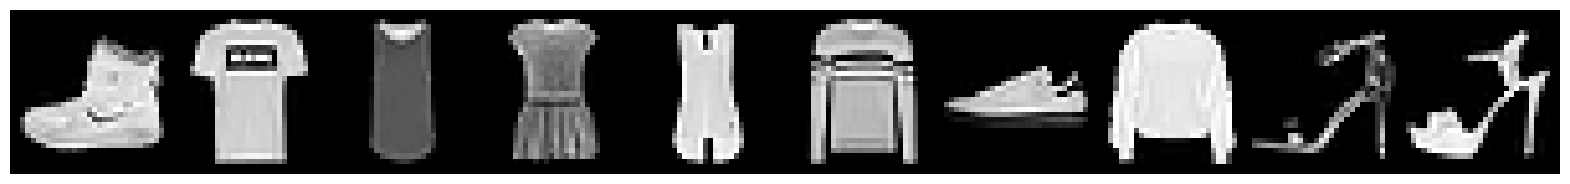

In [3]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

### Solution for task-1

In [4]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
import seaborn as sns
from time import time
import json
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

#### Learn how DataLoader and DataSet work

In [5]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
# """
# understand *_dataset 
# """
# print("*** FashionMNIST Dataset Information: ***")
# print(f"train_dataset is a {type(train_dataset)}.")
# print(f"There are {len(train_dataset)} samples.")
# print(f"At index [n]: a {type(train_dataset[0])} made of a sample and a label")
# print(f"At index [n][0]: a sample {type(train_dataset[0][0])} with {train_dataset[0][0].shape}")  
# print(f"At index [n][1]: a label {type(train_dataset[0][1])}, like {train_dataset[0][1]}, {train_dataset[1][1]}, {train_dataset[3][1]}...") 

*** FashionMNIST Dataset Information: ***
train_dataset is a <class 'torchvision.datasets.mnist.FashionMNIST'>.
There are 60000 samples.
At index [n]: a <class 'tuple'> made of a sample and a label
At index [n][0]: a sample <class 'torch.Tensor'> with torch.Size([1, 28, 28])
At index [n][1]: a label <class 'int'>, like 9, 0, 3...


In [6]:
# """
# understand *_loader
# """
# print("*** torch DataLoader Information: ***")
# print(f"train_loader is a {type(train_loader)}")
# print(f"It can be observed through a iteration view:")
# for batch in train_loader:
#     print(f" - each batch is a {type(batch)}")
#     break
# for i, (inputs, labels) in enumerate(train_loader):
#     print(f"Or read using tuple through i, (inputs, labels), e.g. batch {i + 1}:")
#     print(f"inputs are {type(inputs)}, labels are {type(inputs)}")
#     print(f" - Batch size: {inputs.size(0)}")
#     print(f" - Input shape: {inputs.shape}")
#     print(f" - Labels: {labels[:5]}...") 
#     if i == 0:
#         break

*** torch DataLoader Information: ***
train_loader is a <class 'torch.utils.data.dataloader.DataLoader'>
It can be observed through a iteration view:
 - each batch is a <class 'list'>
Or read using tuple through i, (inputs, labels), e.g. batch 1:
inputs are <class 'torch.Tensor'>, labels are <class 'torch.Tensor'>
 - Batch size: 64
 - Input shape: torch.Size([64, 1, 28, 28])
 - Labels: tensor([5, 1, 1, 6, 5])...


#### 1. initial data for classification tasks

In [7]:
"""
instantiate 'dataloader' in torch
---------
Optimization:
batch size: take advantage of GPU, but increase parameter updating time
num_workers: multi-procedure
"""
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])
train_dataset_clf = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_dataset_clf = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)
train_loader_clf = torch.utils.data.DataLoader(train_dataset_clf, batch_size=64, shuffle=True, num_workers=4)
test_loader_clf = torch.utils.data.DataLoader(test_dataset_clf, batch_size=64, shuffle=False, num_workers=4)
idx_to_class = {v: k for k, v in train_dataset_clf.class_to_idx.items()}

#### 2. class & function definitions

In [8]:
class ClassificationNet(nn.Module):
    def __init__(self, width):
        """
        define CNN classifier
        -------
        conv1: 1*28*28 -> 32*28*28
        pool: 32*28*28 -> 32*14*14
        conv2: 32*14*14 -> 64*14*14
        pool: -> 64*7*7
        fc1: -> 128
        fc2: -> 10
        output_size = (input_size - kernel_size + 2 * padding) / stride +1
        output_size = input_size
        """
        self.width=width
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, width[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(width[0], width[1], kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(width[1] * 7 * 7, width[1]*2)
        self.fc2 = nn.Linear(width[1]*2, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, self.width[1] * 7 * 7) # -1 automatic batch size
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
"""
training procedure
"""
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train() # initialize to training
    start_time = time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device) # load in cuda
            optimizer.zero_grad() # clear grad accumulation in torch
            outputs = model(inputs) # feed forward
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() # .item(): read scaler from tensor
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}") # average loss over iterations,
    end_time = time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

In [10]:
"""
evaluation
"""
def evaluate_model_clf(model, test_loader, criterion=nn.CrossEntropyLoss()):
    model.eval() # set to evaluation
    start_time = time()
    all_preds = []
    all_labels = []
    with torch.no_grad(): # turned off, only in backbpropagate
        total_loss = 0.0
        for inputs, labels in test_loader:
            # testing
            inputs, labels = inputs.to(device), labels.to(device) # load in cuda
            outputs = model(inputs)
            # deal with loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # deal with results
            _, preds = torch.max(outputs, 1) # on 1st dimension, take logits max indeces
            all_preds.extend(preds.cpu().numpy())  # numpy only on cpu
            all_labels.extend(labels.cpu().numpy())  
    end_time = time()
    training_time = end_time - start_time
    print(f"Test loss: {total_loss / len(test_loader)}")
    print(f"Testing time: {training_time:.2f} seconds")
    return all_labels, all_preds

def eval_scores(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted') # weighted based on the class num
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    # return cm, accuracy, precision, recall, f1

def plot_cm(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_PRC(true_labels, pred_labels):
    plt.figure(figsize=(5, 4))
    for i in range(10):
        precision, recall, _ = precision_recall_curve([1 if label == i else 0 for label in true_labels], [1 if label == i else 0 for label in pred_labels])
        plt.plot(recall, precision, label=f'Class {idx_to_class[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def plot_result_images(true_labels, pred_labels):
    x = [test_dataset_clf[i][0] for i in range(10)]
    labels = [idx_to_class[test_dataset_clf[i][1]] for i in range(10)]
    predicted_labels = [idx_to_class[pred_labels[i]] for i in range(10)]
    
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for idx, ax in enumerate(axes):
        ax.imshow(x[idx].numpy().squeeze(), cmap='gray')
        ax.set_title(f'True: {labels[idx]}\nPred: {predicted_labels[idx]}')
        ax.axis('off')
    plt.show()

In [11]:
def excecute_experiment_clf(name, model_param, train_loader, test_loader, criterion, optimizer_param, num_epochs=5):
    """
    the complete procedure
    """
    print(f"Running {name}...")
    model = model_param.to(device)
    optimizer = optimizer_param(model.parameters(), lr=0.001)
    print(f"""--- model: {str(model)}
--- optimizer: {str(optimizer)}
--- criterion: {str(criterion)}
--- epochs: {num_epochs}\n""")
    train_model(model, train_loader, criterion, optimizer, num_epochs)
    true_labels, pred_labels = evaluate_model_clf(model, test_loader)
    eval_scores(true_labels, pred_labels)
    return [true_labels, pred_labels]

#### 3. Training & Evaluation

In [12]:
model_settings = ["Classification task", ClassificationNet([16,32]), train_loader_clf, test_loader_clf, nn.CrossEntropyLoss(), optim.Adam]
model_results = excecute_experiment_clf(*model_settings)

Running Classification task...
--- model: ClassificationNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--- criterion: CrossEntropyLoss()
--- epochs: 5

Epoch 1, Loss: 0.5234136620500703
Epoch 2, Loss: 0.3331932116037747
Epoch 3, Loss: 0.28859906209938563
Epoch 4, Loss: 0.2605200801759577
Epoch 5, Loss: 0.2394440687184077
Training time: 75.77 seconds
Test loss: 0.27455408519999996
Testing time: 7.50 seconds
Accuracy: 0.9018
Precision: 0.9016

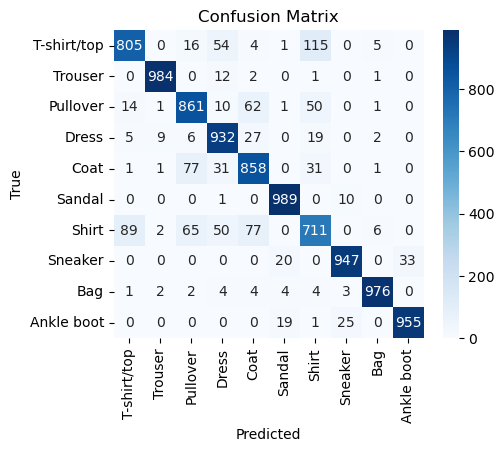

In [13]:
plot_cm(*model_results)

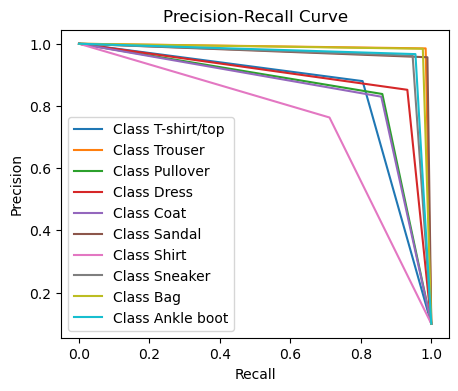

In [14]:
plot_PRC(*model_results)

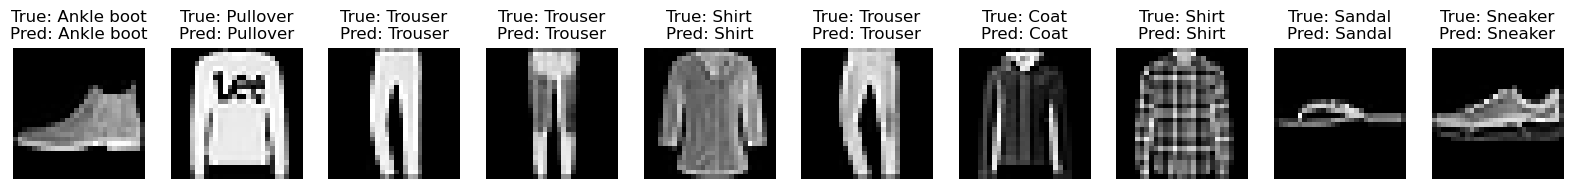

In [15]:
plot_result_images(*model_results)

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [24]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


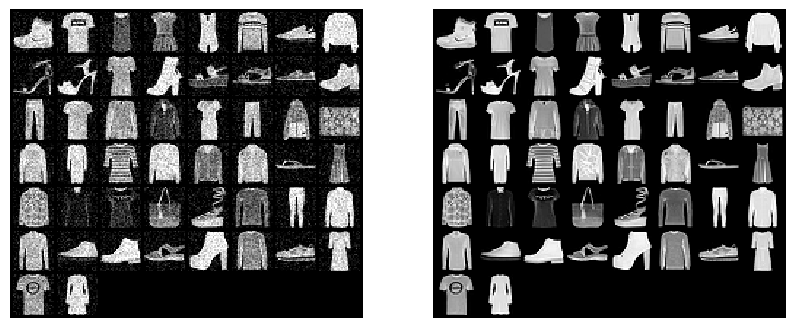

In [25]:
x = [train_dataset[i][0] for i in range(50)]
y = [train_dataset[i][1] for i in range(50)]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
show(torchvision.utils.make_grid(x))
plt.axis('off')

plt.subplot(1,2,2)
show(torchvision.utils.make_grid(y))
plt.axis('off')
plt.show()

#### 1. initalize data for denoising tasks

In [26]:
train_dataset_den = train_dataset
test_dataset_den = test_dataset
train_loader_den = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader_den = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

#### 2. model class and function definitions

In [27]:
class DenoisingNet(nn.Module):
    def __init__(self, width):
        """
        encoder: 1*28*28 -> 64*14*14 -> 128*7*7
        decoder: 128*7*7 -> 64*14*14 -> 1*28*28
        """
        super(DenoisingNet,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, width[0], kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(width[0], width[1], kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(width[1], width[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(width[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
def evaluate_model_den(model, test_loader, criterion=nn.MSELoss()):
    model.eval()
    start_time = time()
    total_loss = 0.0
    with torch.no_grad():
        for noisy_imgs, clean_imgs in test_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            total_loss += loss.item()
    average_loss = total_loss / len(test_loader)
    end_time = time()
    test_time = end_time - start_time
    print(f"Test Loss: {average_loss}")
    print(f"Testing time: {test_time:.2f} seconds")
    return [noisy_imgs, clean_imgs]

def visualize_den(model, test_loader, noisy_imgs, clean_imgs):
    model.eval()
    with torch.no_grad():
        for i, (noisy_imgs, clean_imgs) in enumerate(test_loader):
            if i == 0:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                outputs = model(noisy_imgs)
                outputs = outputs.cpu()
                noisy_imgs = noisy_imgs.cpu()
                clean_imgs = clean_imgs.cpu()
                
                fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 3))
                for j in range(10):
                    axes[0, j].imshow(noisy_imgs[j].squeeze(), cmap='gray')
                    axes[0, j].axis('off')
                    axes[0, j].set_title('Noisy')
                    
                    axes[1, j].imshow(outputs[j].squeeze(), cmap='gray')
                    axes[1, j].axis('off')
                    axes[1, j].set_title('Denoised')
                    
                    axes[2, j].imshow(clean_imgs[j].squeeze(), cmap='gray')
                    axes[2, j].axis('off')
                    axes[2, j].set_title('Clean')
                plt.show()
                break

In [21]:
def excecute_experiment_den(name, model_param, train_loader, test_loader, criterion, optimizer_param, num_epochs=5):
    """
    the complete procedure
    """
    print(f"Running {name}...")
    model = model_param.to(device)
    optimizer = optimizer_param(model.parameters(), lr=0.001)
    print(f"""--- model: {str(model)}
--- optimizer: {str(optimizer)}
--- criterion: {str(criterion)}
--- epochs: {num_epochs}\n""")
    train_model(model, train_loader, criterion, optimizer, num_epochs)
    noisy_imgs, clean_imgs = evaluate_model_den(model, test_loader)
    visualize_den(model, test_loader, noisy_imgs, clean_imgs)
    return [noisy_imgs, clean_imgs]

#### 3. training and evaluation

Running denoising task...
--- model: DenoisingNet(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--- criterion: MSELoss()
--- epochs: 8

Epoch 1, Loss: 0.01408238231297781
Epoch 2, Loss: 0.0033759360101375817
Epoch 3, Loss: 0.003006802900616866
Epoch 4, Loss: 0.002839024527681503
Epoc

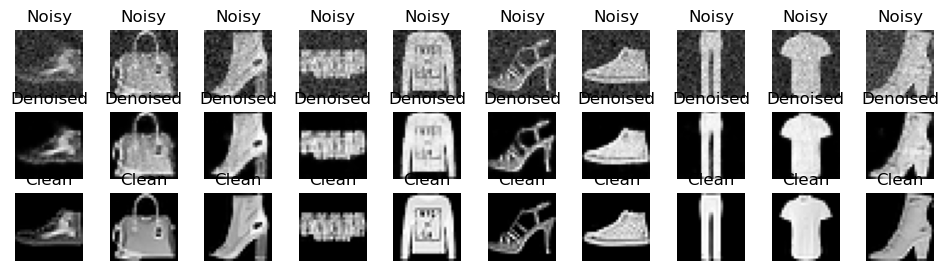

In [23]:
model_settings = ["denoising task", DenoisingNet([32,64]), train_loader_den, test_loader_den, nn.MSELoss(), optim.Adam]
model_results = excecute_experiment_den(*model_settings, 8)

# Task 3: Model Selection

Conduct at least **3 experiments** for **each** of the previous tasks and document them (i.e. at least 6 experiments).  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:
- Evaluate the effect of residual connections
- Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network  
- Evaluate the effect of Batch normalization

## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.

<div style="color: red;">
<p>Here we conduct 3 experiments:</p>

<ul>
  <li>Evaluate the effect of residual connections</li>
  <li>Evaluate the effect of the depth / width of the network</li>
  <li>Evaluate the effect of batch Normalization</li>
</ul>
  <li>** Denoising: the testing loss always appears to be slightly higher than the training loss regardless of the number of epochs. The reason might be that the test set is less complex and this phenomenon doesn't necessarily indicate a underfitting problem. </li>
</div>

<table>
  <tr>
    <th>Task</th>
    <th>Effect</th>
    <th>Tr loss</th>
    <th>Te loss</th>
    <th>Accuracy</th>
    <th>Precision</th>
  </tr>
  <tr>
    <th>classification</th>
    <th>-</th>
    <td>0.2482</td>
    <td>0.2687</td>
    <td>0.9040</td>
    <td>0.9049</td>
  </tr>
  <tr>
    <th>classification</th>
    <th>ResConnection</th>
    <td>0.2458</td>
    <td>0.2775</td>
    <td>0.8992</td>
    <td> 0.8992</td>
  </tr>
  <tr>
    <th>classification</th>
    <th>ResConnection, one more layer</th>
    <td>0.2248</td>
    <td>0.2571</td>
    <td>0.9066</td>
    <td>0.9129</td>
  </tr>
  <tr>
    <th>classification</th>
    <th>2-time width in each layer, unchanged depth</th>
    <td>0.1962</td>
    <td>0.2456</td>
    <td>0.9143</td>
    <td>0.9144</td>
  </tr>
  <tr>
    <th>classification</th>
    <th>unchanged width, one more layer</th>
    <td>0.2601</td>
    <td>0.3082</td>
    <td>0.8865</td>
    <td>0.8879</td>
  </tr>
  <tr>
    <th>classification</th>
    <th>batch normaliazation</th>
    <td>0.1930</td>
    <td>0.2500</td>
    <td>0.9128</td>
    <td>0.9130</td>
  </tr>
  <tr>
    <th>denoising</th>
    <th>-</th>
    <td>0.0029</td>
    <td>0.0028</td>
    <td>/</td>
    <td>/</td>
  </tr>
  <tr>
    <th>denoising</th>
    <th>ResConnection</th>
    <td>0.0036</td>
    <td>0.0035</td>
    <td>/</td>
    <td>/</td>
  </tr>
  <tr>
    <th>denoising</th>
    <th>2-time width in each layer, unchanged depth</th>
    <td>0.0028</td>
    <td>0.0028</td>
    <td>/</td>
    <td>/</td>
  </tr>
  <tr>
    <th>denoising</th>
    <th>unchanged width, one more layer</th>
    <td>0.0062</td>
    <td>0.0059</td>
    <td>/</td>
    <td>/</td>
  </tr>
  <tr>
    <th>denoising</th>
    <th>batch normaliazation</th>
    <td>0.0025</td>
    <td>0.0024</td>
    <td>/</td>
    <td>/</td>
  </tr>
</table>

<div style="color: green;">
<p>Analysis:</p>
<ul>
    <li>Exploit only residual connection doesn't necessarily improve the performance, and adding one layer make the model even worse on both tasks. But combining these 2 methods can slightly optimize the model. </li>
    <li>Expanding the layer width and especially using batch normalization can improve the classification as well as denoising performance on the CNN and the autoencoder network. </li>
</ul>
</div>

### Experiment 1: Evaluate the effect of residual connections

#### 1. classification task

In [35]:
import torch
from torch import nn

class ResClassificationNet(nn.Module):
    """
    Create residual blocks for classification
    """
    def __init__(self):
        super(ResClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.residual_conv1 = nn.Conv2d(1, 16, kernel_size=1)
        self.residual_conv2 = nn.Conv2d(16, 32, kernel_size=1)
        self.residual_conv3 = nn.Conv2d(32, 64, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        residual1 = self.residual_conv1(x)
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        residual1 = self.pool(residual1)
        x += residual1  # Add residual connection

        residual2 = self.residual_conv2(x)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        residual2 = self.pool(residual2)
        x += residual2  # Add residual connection

        residual3 = self.residual_conv3(x)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        residual3 = self.pool(residual3)
        x += residual3  # Add residual connection

        x = x.view(-1, 64 * 3 * 3)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Example usage:
# model = ResClassificationNet()
# print(model)


In [36]:
model_settings = ["classification task with ResConnection", ResClassificationNet(), train_loader_clf, test_loader_clf, nn.CrossEntropyLoss(), optim.Adam]
model_results = excecute_experiment_clf(*model_settings)

Running classification task with ResConnection...
--- model: ResClassificationNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_conv1): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  (residual_conv2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (residual_conv3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (

#### 2. denoising task

In [27]:
class ResidualDenoisingNet(nn.Module):
    def __init__(self, width):
        """
        add one residual connection
        """
        super(ResidualDenoisingNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, width[0], kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(width[0], width[1], kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(width[1], width[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(width[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.residual_conv = nn.Conv2d(1, width[1], kernel_size=1)

    def forward(self, x):
        residual = self.residual_conv(x) 
        x = self.encoder(x)
        x += residual
        x = self.decoder(x)
        return x

Running denoising task with ResConnection...
--- model: DenoisingNet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--- criterion: MSELoss()
--- epochs: 5

Epoch 1, Loss: 0.024173382197075814
Epoch 2, Loss: 0.0054944956969064694
Epoch 3, Loss: 0.004367508878832115
Epoch 4, Loss: 0.003

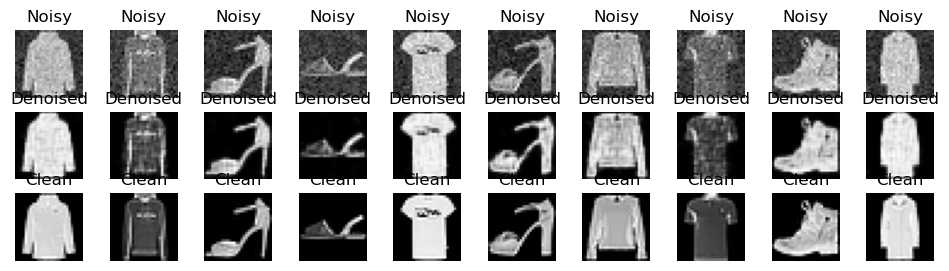

In [28]:
model_settings = ["denoising task with ResConnection", DenoisingNet([16,32]), train_loader_den, test_loader_den, nn.MSELoss(), optim.Adam]
model_results = excecute_experiment_den(*model_settings)

### Experiment 2: Evaluate the effect of the depth / width of the network  

#### 1.1 Classification task: 2 convolutional layers with width 32, 64

In [29]:
model_settings = ["classification task with wider network", ClassificationNet([32,64]), train_loader_clf, test_loader_clf, nn.CrossEntropyLoss(), optim.Adam]
model_results = excecute_experiment_clf(*model_settings)

Running classification task with wider network...
--- model: ClassificationNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--- criterion: CrossEntropyLoss()
--- epochs: 5

Epoch 1, Loss: 0.46761477165130666
Epoch 2, Loss: 0.29472834222129923
Epoch 3, Loss: 0.2512666249929715
Epoch 4, Loss: 0.22200501215324472
Epoch 5, Loss: 0.19625525716652495
Training time: 68.50 seconds
Test loss: 0.24563583558437171
Testing time: 8.17 seconds
Accuracy: 

#### 1.2 Classification task: 3 convolutional layers with width 16, 32 64

In [30]:
class ClassificationNetDeep(nn.Module):
    def __init__(self, width):
        self.width=width
        super(ClassificationNetDeep, self).__init__()
        self.conv1 = nn.Conv2d(1, width[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(width[0], width[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(width[1], width[2], kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(width[2] * 7 * 7, width[2]*2)
        self.fc2 = nn.Linear(width[2]*2, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, self.width[2] * 7 * 7) # -1 automatic batch size
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
model_settings = ["classification task with deeper network", ClassificationNetDeep([8,16,32]), train_loader_clf, test_loader_clf, nn.CrossEntropyLoss(), optim.Adam]
model_results = excecute_experiment_clf(*model_settings)

Running classification task with deeper network...
--- model: ClassificationNetDeep(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--- criterion: CrossEntropyLoss()
--- epochs: 5

Epoch 1, Loss: 0.5857074971932338
Epoch 2, Loss: 0.36702246727274934
Epoch 3, Loss: 0.3125204955463979
Epoch 4, Loss: 0.2838313982510236
Epoch 5, Loss: 0.2601301894942199
Training time: 69.10 s

#### 2.1 Denoising task: 2 convolutional layers with width 32, 64

Running denoising task with wider network...
--- model: DenoisingNet(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--- criterion: MSELoss()
--- epochs: 5

Epoch 1, Loss: 0.013202634615215984
Epoch 2, Loss: 0.0037138638928580258
Epoch 3, Loss: 0.003228613093539056
Epoch 4, Loss: 0.003

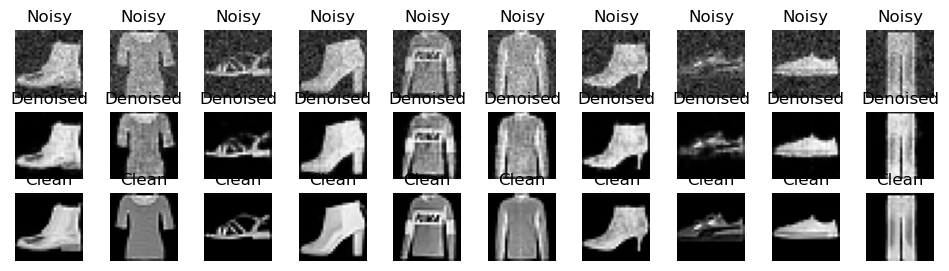

In [32]:
model_settings = ["denoising task with wider network", DenoisingNet([32,64]), train_loader_den, test_loader_den, nn.MSELoss(), optim.Adam]
model_results = excecute_experiment_den(*model_settings)

#### 2.2 Denoising task: 3 convolutional layers with width 8, 16, 32

In [33]:
class DenoisingNetDeep(nn.Module):
    def __init__(self, width):
        """
        encoder: 1*28*28 -> width[0]*14*14 -> width[1]*7*7 -> width[2]*4*4
        decoder: width[2]*4*4 -> width[1]*7*7 -> width[0]*14*14 -> 1*28*28
        """
        super(DenoisingNetDeep, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, width[0], kernel_size=3, stride=2, padding=1),  # [B, width[0], 14, 14]
            nn.ReLU(True),
            nn.Conv2d(width[0], width[1], kernel_size=3, stride=2, padding=1),  # [B, width[1], 7, 7]
            nn.ReLU(True),
            nn.Conv2d(width[1], width[2], kernel_size=3, stride=2, padding=1),  # [B, width[2], 4, 4]
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(width[2], width[1], kernel_size=3, stride=2, padding=1, output_padding=0),  # [B, width[1], 7, 7]
            nn.ReLU(True),
            nn.ConvTranspose2d(width[1], width[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, width[0], 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(width[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Running denoising task with wider network...
--- model: DenoisingNetDeep(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr

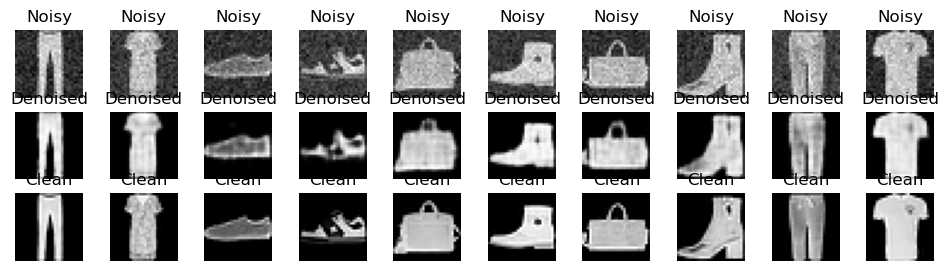

In [34]:
model_settings = ["denoising task with wider network", DenoisingNetDeep([16,32,64]), train_loader_den, test_loader_den, nn.MSELoss(), optim.Adam]
model_results = excecute_experiment_den(*model_settings)

### Experiment 3: Batch Normalization

#### 1. classification task

In [35]:
class ClassificationNetBN(nn.Module):
    def __init__(self):
        super(ClassificationNetBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [36]:
model_settings = ["classification task with batch normalization", ClassificationNetBN(), train_loader_clf, test_loader_clf, nn.CrossEntropyLoss(), optim.Adam]
model_results = excecute_experiment_clf(*model_settings)

Running classification task with batch normalization...
--- model: ClassificationNetBN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--- criterion: CrossEntropyLoss()
--- epochs: 5

Epoch 1, Loss: 0.39318349837526073
Epoch 2, Loss: 0.27137990222016634
Epoch 3, Loss: 0.

#### 2. denoising task

In [37]:
class DenoisingNetBN(nn.Module):
    def __init__(self):
        super(DenoisingNetBN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Running denoising task with batch normalization...
--- model: DenoisingNetBN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Sigmoid()
  )
)
--- optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False

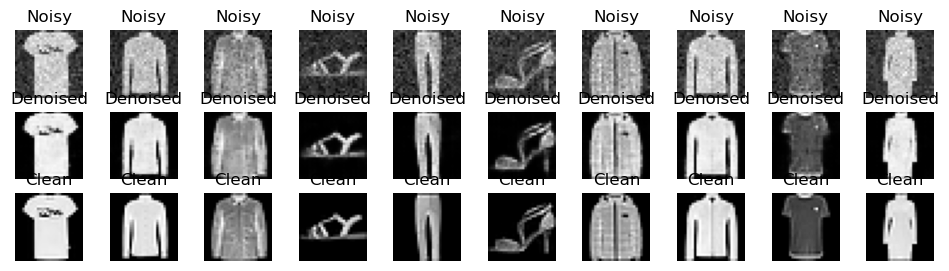

In [38]:
model_settings = ["denoising task with batch normalization", DenoisingNetBN(), train_loader_den, test_loader_den, nn.MSELoss(), optim.Adam]
model_results = excecute_experiment_den(*model_settings)